# ECE9063 Project

Hyperparameters
- number of convolution layers
- number of filters
- filter size
- number of dense layers
- dense layer units
- batch size
- learning rate
- epochs
- kernel regularizer
- dropout

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

import os
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

## Load data

In [2]:
folder_path = './Data/images/cropped'
target_size = (224, 224)
ignore_small = True
factor = 0.1

In [3]:
def load_data_from_folder(folder):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = tf.keras.utils.load_img(img_path, target_size=None)
        if ignore_small and (img.width < target_size[0]*factor or img.height < target_size[1]*factor):
            continue
        img = img.resize(target_size)
        img_array = tf.keras.utils.img_to_array(img)/255
        label = 1 if filename.endswith('T.png') else 0  # 1 for 'T' (with helmet), 0 for 'F' (without helmet)
        images.append(img_array)
        labels.append(int(label))
    return np.array(images), np.array(labels)

In [4]:
images, labels = load_data_from_folder(folder_path)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.2, random_state=42
)

In [6]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [7]:
print(X_train.shape)
print(X_test.shape)

(914, 224, 224, 3)
(115, 224, 224, 3)


In [8]:
unique_elements, counts = np.unique(y_train, return_counts=True)

# Print the results
for element, count in zip(unique_elements, counts):
    print(f"{element}: {count} occurrences")

0: 276 occurrences
1: 638 occurrences


In [9]:
def plot_cost_function(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    # Add labels and title
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('CNN Training Accuracy')
    plt.legend()

    # Show the plot
    plt.show()

In [10]:
print(y_val.shape)
print(y_test.shape)

(114,)
(115,)


In [11]:
def print_metrics(model):
    test_loss, test_accuracy, test_precision, test_recall = model.evaluate(X_test, y_test)
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

    y_pred = np.round(model.predict(X_test)).astype(int)
    cm = confusion_matrix(y_test,y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Without Helmet', 'With Helmet'])
    disp.plot(cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()

    f1 = f1_score(y_test, y_pred)
    print(f"F1 Score: {f1:.4f}")

In [12]:
additional_metrics = [Precision(), Recall()]

In [13]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

## Base Model

### sigmoid

In [183]:
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

Epoch 1/10
29/29 [==============================] - 5s 138ms/step - loss: 0.5238 - accuracy: 0.7177 - precision_2: 0.7378 - recall_2: 0.9485 - val_loss: 0.3463 - val_accuracy: 0.8421 - val_precision_2: 0.8696 - val_recall_2: 0.9302
Epoch 2/10
29/29 [==============================] - 4s 136ms/step - loss: 0.4439 - accuracy: 0.8031 - precision_2: 0.8290 - recall_2: 0.9044 - val_loss: 0.3513 - val_accuracy: 0.8860 - val_precision_2: 0.8842 - val_recall_2: 0.9767
Epoch 3/10
29/29 [==============================] - 4s 143ms/step - loss: 0.3607 - accuracy: 0.8556 - precision_2: 0.8721 - recall_2: 0.9295 - val_loss: 0.3371 - val_accuracy: 0.8860 - val_precision_2: 0.9195 - val_recall_2: 0.9302
Epoch 4/10
29/29 [==============================] - 4s 136ms/step - loss: 0.3456 - accuracy: 0.8490 - precision_2: 0.8754 - recall_2: 0.9138 - val_loss: 0.2982 - val_accuracy: 0.8860 - val_precision_2: 0.9011 - val_recall_2: 0.9535
Epoch 5/10
29/29 [==============================] - 4s 137ms/step - loss

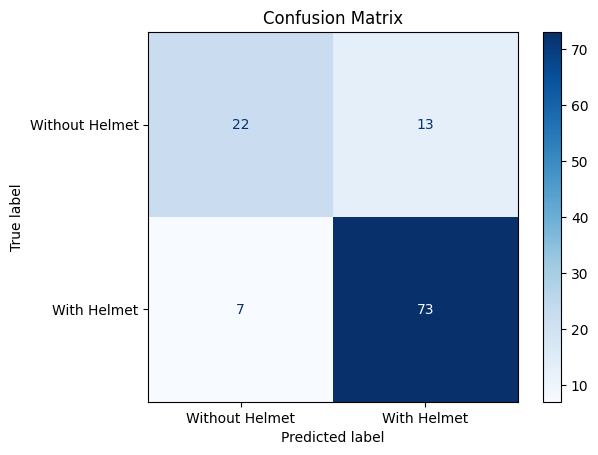

F1 Score: 0.8795


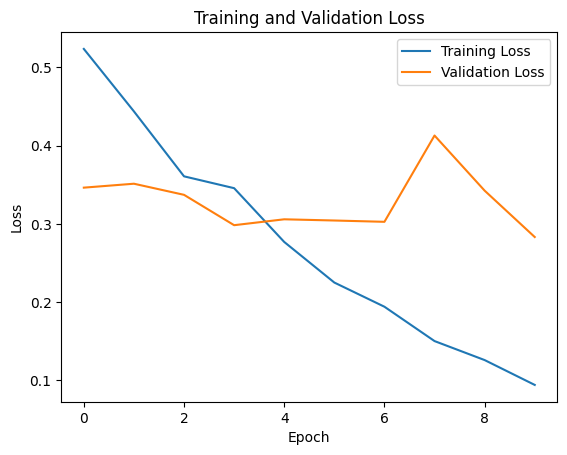

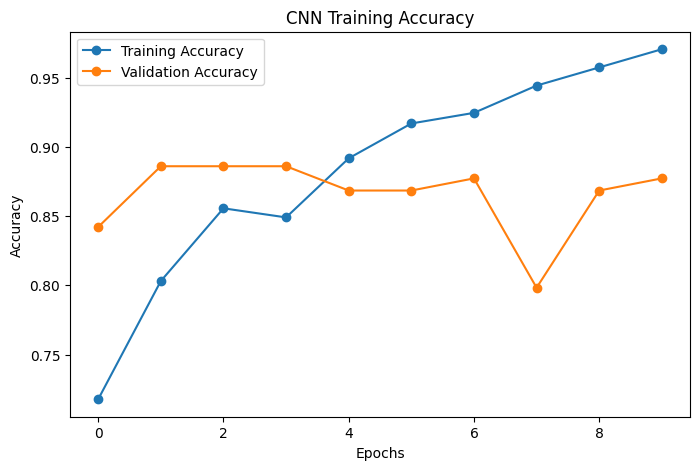

In [184]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'] + additional_metrics)

history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), callbacks=None)

print_metrics(model)
plot_cost_function(history)

### softmax

Epoch 1/10
29/29 [==============================] - 5s 142ms/step - loss: 0.5211 - accuracy: 0.6980 - precision_2: 0.7099 - recall_2: 0.9916 - val_loss: 0.3627 - val_accuracy: 0.7544 - val_precision_2: 0.7544 - val_recall_2: 1.0000
Epoch 2/10
29/29 [==============================] - 4s 130ms/step - loss: 0.3947 - accuracy: 0.6980 - precision_2: 0.6980 - recall_2: 1.0000 - val_loss: 0.3165 - val_accuracy: 0.7544 - val_precision_2: 0.7544 - val_recall_2: 1.0000
Epoch 3/10
29/29 [==============================] - 4s 130ms/step - loss: 0.3580 - accuracy: 0.6980 - precision_2: 0.6980 - recall_2: 1.0000 - val_loss: 0.3673 - val_accuracy: 0.7544 - val_precision_2: 0.7544 - val_recall_2: 1.0000
Epoch 4/10
29/29 [==============================] - 4s 129ms/step - loss: 0.3107 - accuracy: 0.6980 - precision_2: 0.6980 - recall_2: 1.0000 - val_loss: 0.2943 - val_accuracy: 0.7544 - val_precision_2: 0.7544 - val_recall_2: 1.0000
Epoch 5/10
29/29 [==============================] - 4s 129ms/step - loss

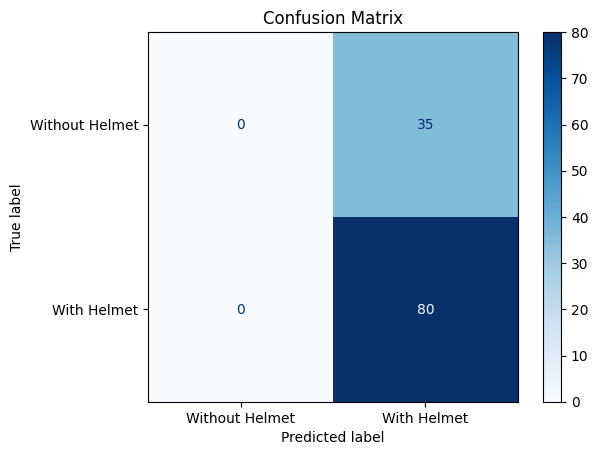

F1 Score: 0.8205


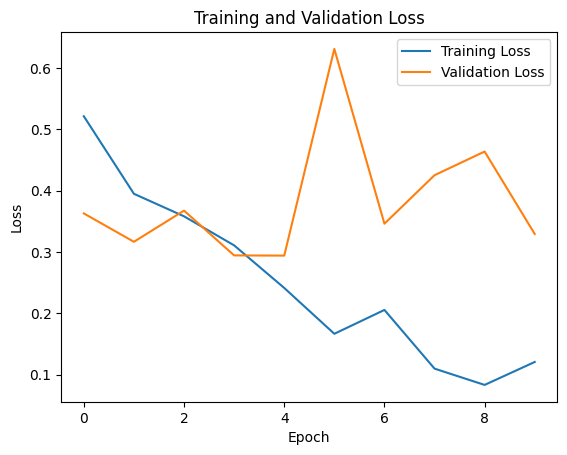

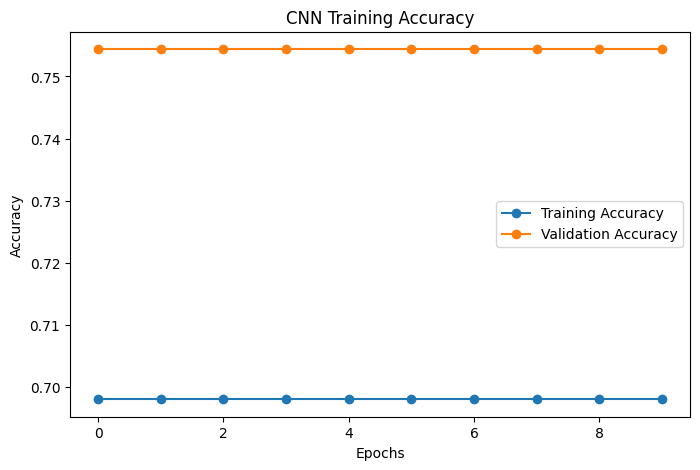

In [144]:
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'] + additional_metrics)

history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), callbacks=None)

print_metrics(model)
plot_cost_function(history)

### relu

Epoch 1/10
29/29 [==============================] - 5s 137ms/step - loss: 8.6703 - accuracy: 0.4015 - precision_2: 0.7125 - recall_2: 0.3175 - val_loss: 11.6364 - val_accuracy: 0.2456 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 2/10
29/29 [==============================] - 4s 125ms/step - loss: 10.7671 - accuracy: 0.3020 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_loss: 11.6364 - val_accuracy: 0.2456 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 3/10
29/29 [==============================] - 4s 126ms/step - loss: 10.7671 - accuracy: 0.3020 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_loss: 11.6364 - val_accuracy: 0.2456 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 4/10
29/29 [==============================] - 4s 127ms/step - loss: 10.7671 - accuracy: 0.3020 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_loss: 11.6364 - val_accuracy: 0.2456 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 5/1

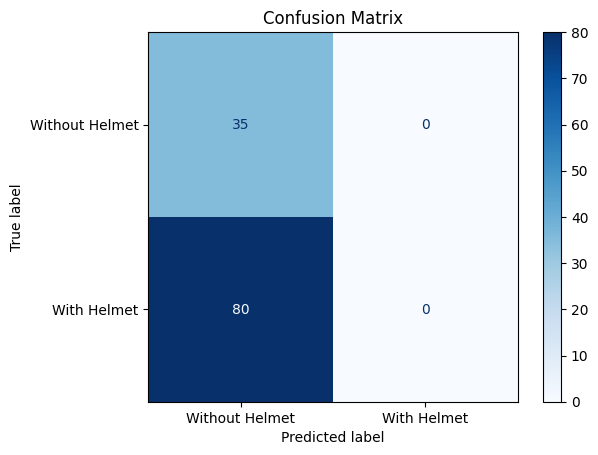

F1 Score: 0.0000


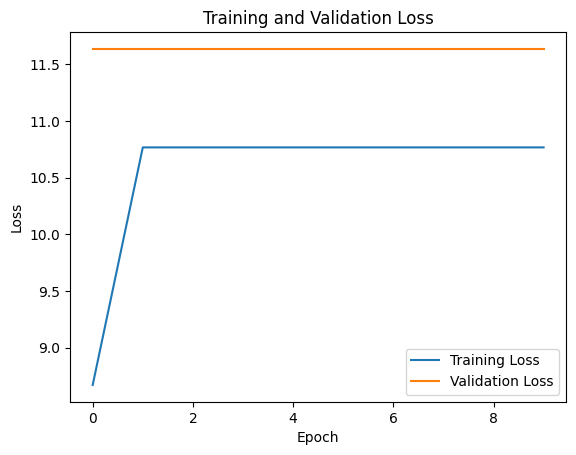

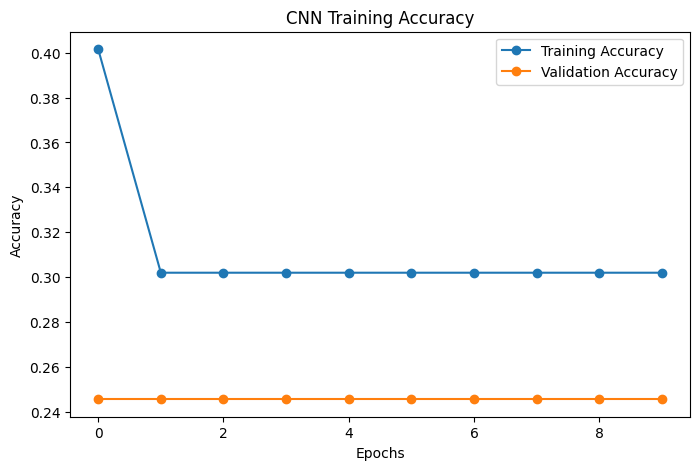

In [145]:
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='relu'))

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'] + additional_metrics)

history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), callbacks=None)

print_metrics(model)
plot_cost_function(history)

### L2 regularizer

Epoch 1/10
29/29 [==============================] - 5s 135ms/step - loss: 1.0510 - accuracy: 0.6958 - precision_2: 0.7055 - recall_2: 0.8607 - val_loss: 0.7640 - val_accuracy: 0.8070 - val_precision_2: 0.7963 - val_recall_2: 1.0000
Epoch 2/10
29/29 [==============================] - 4s 128ms/step - loss: 0.7536 - accuracy: 0.8031 - precision_2: 0.8005 - recall_2: 0.9561 - val_loss: 0.5998 - val_accuracy: 0.8684 - val_precision_2: 0.8817 - val_recall_2: 0.9535
Epoch 3/10
29/29 [==============================] - 4s 128ms/step - loss: 0.6535 - accuracy: 0.8140 - precision_2: 0.8296 - recall_2: 0.9232 - val_loss: 0.5296 - val_accuracy: 0.8684 - val_precision_2: 0.8737 - val_recall_2: 0.9651
Epoch 4/10
29/29 [==============================] - 4s 129ms/step - loss: 0.5737 - accuracy: 0.8425 - precision_2: 0.8611 - recall_2: 0.9232 - val_loss: 0.5117 - val_accuracy: 0.8158 - val_precision_2: 0.8155 - val_recall_2: 0.9767
Epoch 5/10
29/29 [==============================] - 4s 128ms/step - loss

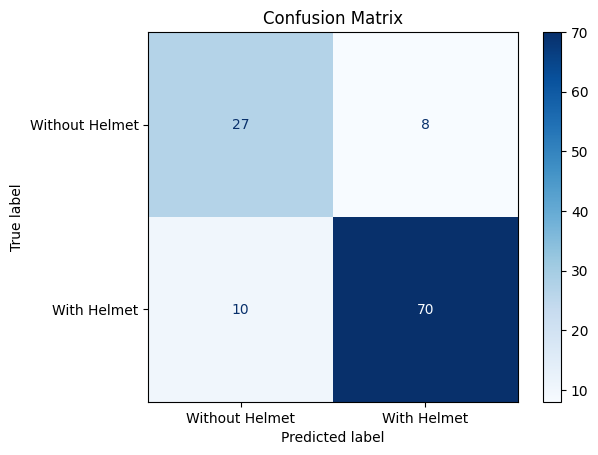

F1 Score: 0.8861


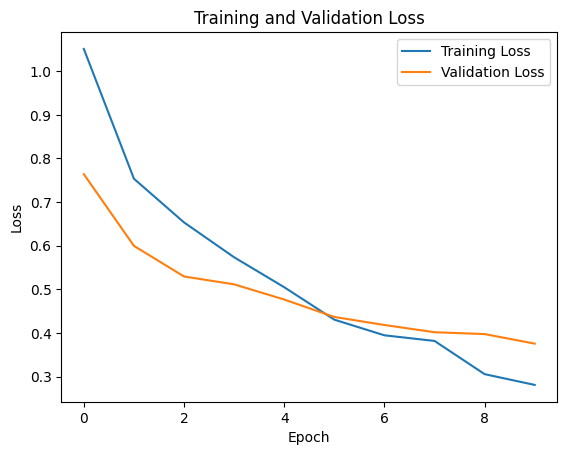

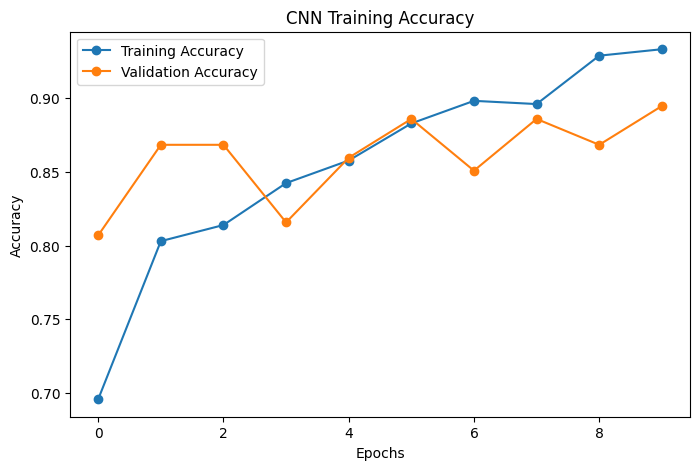

In [146]:
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'] + additional_metrics)

history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), callbacks=None)

print_metrics(model)
plot_cost_function(history)

## Bayesian Optimization

### CNN

In [15]:
from skopt import BayesSearchCV
from sklearn.model_selection import StratifiedKFold
import keras
from sklearn.base import BaseEstimator, ClassifierMixin

print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

In [152]:
class KerasClassifierWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, num_filters_0=16, num_filters_1=16, num_filters_2=16, num_units_0=16, num_units_1=16):
        self.num_filters_0 = num_filters_0
        self.num_filters_1 = num_filters_1
        self.num_filters_2 = num_filters_2
        self.num_units_0 = num_units_0
        self.num_units_1 = num_units_1
        self.classes_ = [0, 1]
        self.model = self.create_model()

    def create_model(self):
        model = Sequential()
        model.add(Conv2D(self.num_filters_0, kernel_size=(3, 3), activation='relu', input_shape=(target_size[0], target_size[1], 3)))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        #model.add(Dropout(self.dropout_rate))
        model.add(Conv2D(self.num_filters_1, kernel_size=(3, 3), activation='relu',kernel_regularizer=l2(0.01)))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        #model.add(Dropout(self.dropout_rate))
        model.add(Conv2D(self.num_filters_2, kernel_size=(3, 3), activation='relu',kernel_regularizer=l2(0.01)))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Flatten())
        model.add(Dense(self.num_units_0, activation='relu'))
        model.add(Dense(self.num_units_1, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))

        model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0005), metrics=['accuracy'])
        return model

    def fit(self, X, y):
        global X_val, y_val
        #X_val, y_val = X_val, y_val
        print(self.num_filters_0,self.num_filters_1,self.num_filters_2,self.num_units_0,self.num_units_1)
        self.model.fit(X, y, epochs=10, validation_data=(X_val, y_val), callbacks=None)
        return self

    def predict(self, X):
        return np.round(self.model.predict(X))

In [153]:
def val_accuracy_scorer(estimator, X, y):
    y_pred = estimator.predict(X)
    val_accuracy = accuracy_score(y, y_pred)
    print("Score: ",val_accuracy)
    return val_accuracy

In [154]:
hp_space = {
    'num_filters_0': (16, 128),
    'num_filters_1': (16, 128),
    'num_filters_2': (16, 128),
    'num_units_0' : (16, 128),
    'num_units_1' : (16, 128),
}

In [155]:
keras_model_wrapper = KerasClassifierWrapper()

In [156]:
opt = BayesSearchCV(
    keras_model_wrapper,
    hp_space,
    n_iter=10,
    cv=3,
    scoring=val_accuracy_scorer,
    random_state=42,
)

In [157]:
opt.fit(X_train, y_train)

62 98 120 51 91
Epoch 1/10
20/20 [==============================] - 3s 87ms/step - loss: 0.8776 - accuracy: 0.6995 - val_loss: 0.8048 - val_accuracy: 0.7544
Epoch 2/10
20/20 [==============================] - 2s 82ms/step - loss: 0.8264 - accuracy: 0.6979 - val_loss: 0.7120 - val_accuracy: 0.7544
Epoch 3/10
20/20 [==============================] - 2s 79ms/step - loss: 0.7365 - accuracy: 0.7126 - val_loss: 0.6197 - val_accuracy: 0.7895
Epoch 4/10
20/20 [==============================] - 2s 79ms/step - loss: 0.6709 - accuracy: 0.7997 - val_loss: 0.5728 - val_accuracy: 0.8509
Epoch 5/10
20/20 [==============================] - 2s 81ms/step - loss: 0.6048 - accuracy: 0.8358 - val_loss: 0.5362 - val_accuracy: 0.8509
Epoch 6/10
20/20 [==============================] - 2s 80ms/step - loss: 0.6135 - accuracy: 0.8062 - val_loss: 0.5833 - val_accuracy: 0.8860
Epoch 7/10
20/20 [==============================] - 2s 79ms/step - loss: 0.5483 - accuracy: 0.8506 - val_loss: 0.4849 - val_accuracy: 0.85

BayesSearchCV(cv=3, estimator=KerasClassifierWrapper(), n_iter=10,
              random_state=42,
              scoring=<function val_accuracy_scorer at 0x0000021986309620>,
              search_spaces={'num_filters_0': (16, 128),
                             'num_filters_1': (16, 128),
                             'num_filters_2': (16, 128),
                             'num_units_0': (16, 128),
                             'num_units_1': (16, 128)})

In [158]:
best_params = opt.best_params_
print(best_params)

OrderedDict([('num_filters_0', 123), ('num_filters_1', 94), ('num_filters_2', 114), ('num_units_0', 63), ('num_units_1', 59)])


In [104]:
def opt_cnn_model(learning_rate, num_filters_0, num_filters_1, num_filters_2, num_units_0, num_units_1):
    model = Sequential()
    model.add(Conv2D(num_filters_0, kernel_size=(3, 3), activation='relu', input_shape=(target_size[0], target_size[1], 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    #model.add(Dropout(0.5))
    model.add(Conv2D(num_filters_1, kernel_size=(3, 3), activation='relu',kernel_regularizer=l2(0.01)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    #model.add(Dropout(0.5))
    model.add(Conv2D(num_filters_2, kernel_size=(3, 3), activation='relu',kernel_regularizer=l2(0.01)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(num_units_0, activation='relu'))
    model.add(Dense(num_units_1, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'] + additional_metrics)
    return model

Epoch 1/10
29/29 [==============================] - 55s 2s/step - loss: 1.8546 - accuracy: 0.6871 - precision_2: 0.7108 - recall_2: 0.9373 - val_loss: 1.0750 - val_accuracy: 0.7895 - val_precision_2: 0.7925 - val_recall_2: 0.9767
Epoch 2/10
29/29 [==============================] - 55s 2s/step - loss: 0.9258 - accuracy: 0.7899 - precision_2: 0.8063 - recall_2: 0.9201 - val_loss: 0.9417 - val_accuracy: 0.6579 - val_precision_2: 0.9608 - val_recall_2: 0.5698
Epoch 3/10
29/29 [==============================] - 67s 2s/step - loss: 0.7028 - accuracy: 0.7823 - precision_2: 0.8003 - recall_2: 0.9169 - val_loss: 0.6010 - val_accuracy: 0.8421 - val_precision_2: 0.9146 - val_recall_2: 0.8721
Epoch 4/10
29/29 [==============================] - 70s 2s/step - loss: 0.5560 - accuracy: 0.8228 - precision_2: 0.8480 - recall_2: 0.9091 - val_loss: 0.4794 - val_accuracy: 0.8596 - val_precision_2: 0.9167 - val_recall_2: 0.8953
Epoch 5/10
29/29 [==============================] - 66s 2s/step - loss: 0.5028 -

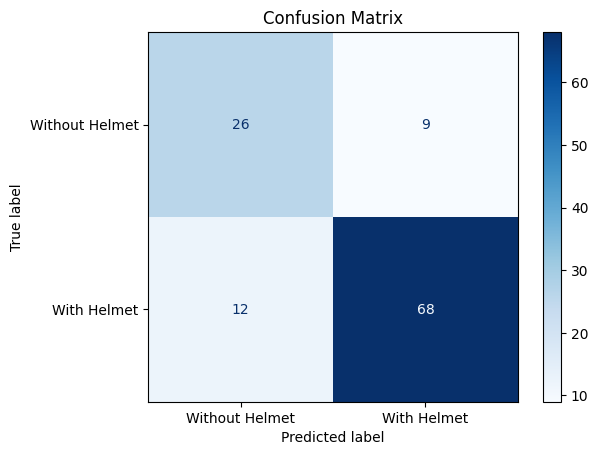

F1 Score: 0.8662


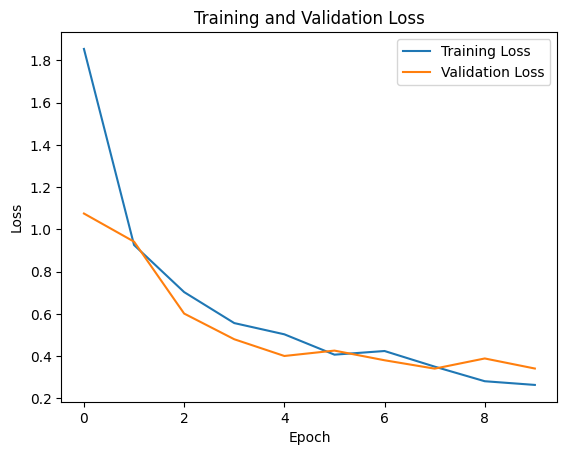

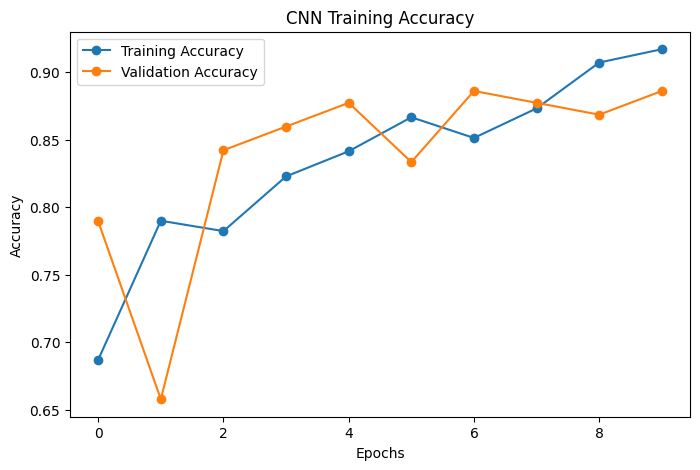

In [177]:
model = opt_cnn_model(0.001, 123, 94, 114, 63, 59)
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), callbacks=None)
print_metrics(model)
plot_cost_function(history)

Epoch 1/15
29/29 [==============================] - 60s 2s/step - loss: 2.6148 - accuracy: 0.6871 - precision_2: 0.7164 - recall_2: 0.9499 - val_loss: 2.4486 - val_accuracy: 0.7544 - val_precision_2: 0.7544 - val_recall_2: 1.0000
Epoch 2/15
29/29 [==============================] - 57s 2s/step - loss: 2.4203 - accuracy: 0.7177 - precision_2: 0.7149 - recall_2: 0.9906 - val_loss: 2.2522 - val_accuracy: 0.7895 - val_precision_2: 0.7870 - val_recall_2: 0.9884
Epoch 3/15
29/29 [==============================] - 63s 2s/step - loss: 2.2369 - accuracy: 0.8074 - precision_2: 0.7992 - recall_2: 0.9671 - val_loss: 2.1836 - val_accuracy: 0.8596 - val_precision_2: 0.9605 - val_recall_2: 0.8488
Epoch 4/15
29/29 [==============================] - 61s 2s/step - loss: 2.0880 - accuracy: 0.8403 - precision_2: 0.8465 - recall_2: 0.9420 - val_loss: 1.9773 - val_accuracy: 0.8772 - val_precision_2: 0.8830 - val_recall_2: 0.9651
Epoch 5/15
29/29 [==============================] - 57s 2s/step - loss: 1.9863 -

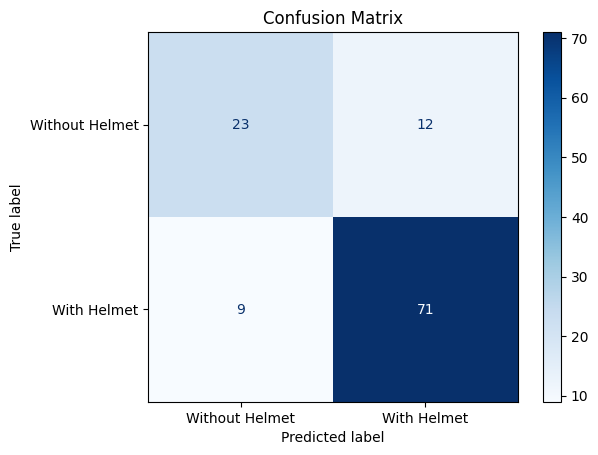

F1 Score: 0.8712


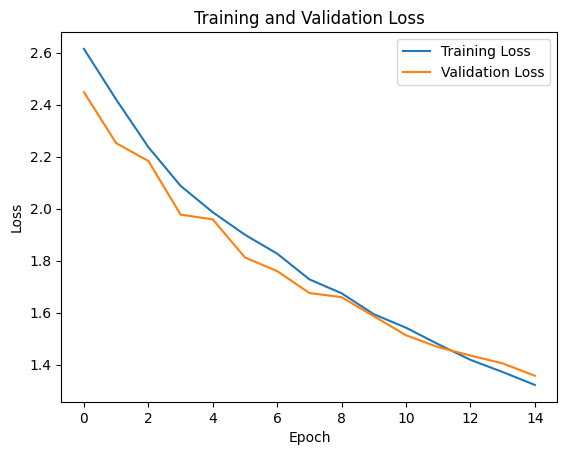

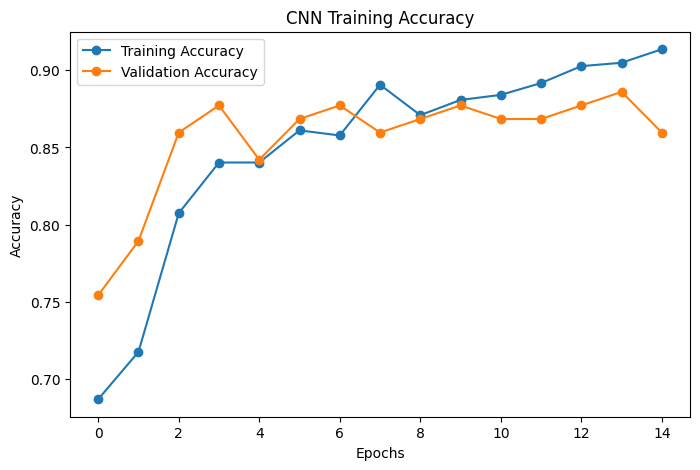

In [190]:
model = opt_cnn_model(0.00005, 123, 94, 114, 63, 59)
history = model.fit(X_train, y_train, epochs=15, validation_data=(X_val, y_val), callbacks=None)
print_metrics(model)
plot_cost_function(history)

### MLP

In [16]:
class KerasClassifierWrapper_mlp(BaseEstimator, ClassifierMixin):
    def __init__(self, num_units_0=128, num_units_1=256, num_units_2=256):
        self.num_units_0 = num_units_0
        self.num_units_1 = num_units_1
        self.num_units_2 = num_units_2
        self.classes_ = [0, 1]
        self.model = self.create_model()

    def create_model(self):
        model = Sequential()
        model.add(Flatten(input_shape=(target_size[0], target_size[1], 3)))  # Flatten the images
        model.add(Dense(self.num_units_0, activation='relu'))  
        model.add(Dense(self.num_units_1, activation='relu'))
        model.add(Dense(self.num_units_2, activation='relu'))   
        model.add(Dense(1, activation='sigmoid'))

        model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0005), metrics=['accuracy'])
        return model

    def fit(self, X, y):
        global X_val, y_val
        #X_val, y_val = X_val, y_val
        print(self.num_units_0,self.num_units_1,self.num_units_2)
        self.model.fit(X, y, epochs=10, validation_data=(X_val, y_val), callbacks=None)
        return self

    def predict(self, X):
        return np.round(self.model.predict(X))

In [17]:
def val_accuracy_scorer_mlp(estimator, X, y):
    y_pred = estimator.predict(X)
    val_accuracy = accuracy_score(y, y_pred)
    print("Score: ",val_accuracy)
    return val_accuracy

In [18]:
hp_space_mlp= {
    'num_units_0' : (16, 128),
    'num_units_1' : (16, 128),
    'num_units_2' : (16, 128),
}

In [19]:
keras_model_wrapper = KerasClassifierWrapper_mlp()

In [21]:
opt = BayesSearchCV(
    keras_model_wrapper,
    hp_space_mlp,
    n_iter=10,
    cv=3,
    scoring=val_accuracy_scorer_mlp,
    random_state=42,
)

In [22]:
opt.fit(X_train, y_train)

62 98 120
Epoch 1/10


20/20 [==============================] - 4s 137ms/step - loss: 2.4230 - accuracy: 0.6059 - val_loss: 0.4241 - val_accuracy: 0.8158
Epoch 2/10
20/20 [==============================] - 3s 129ms/step - loss: 0.7314 - accuracy: 0.7143 - val_loss: 0.4283 - val_accuracy: 0.8333
Epoch 3/10
20/20 [==============================] - 3s 131ms/step - loss: 0.5117 - accuracy: 0.7767 - val_loss: 2.4402 - val_accuracy: 0.2982
Epoch 4/10
20/20 [==============================] - 3s 129ms/step - loss: 1.1535 - accuracy: 0.6486 - val_loss: 0.4283 - val_accuracy: 0.8509
Epoch 5/10
20/20 [==============================] - 3s 128ms/step - loss: 0.6006 - accuracy: 0.7537 - val_loss: 0.5194 - val_accuracy: 0.8070
Epoch 6/10
20/20 [==============================] - 3s 128ms/step - loss: 0.4855 - accuracy: 0.7750 - val_loss: 0.3971 - val_accuracy: 0.8509
Epoch 7/10
20/20 [==============================] - 3s 128ms/step - loss: 0.5832 - accuracy: 0.7274 - val_loss: 0.5392 - val_accuracy: 0

BayesSearchCV(cv=3, estimator=KerasClassifierWrapper_mlp(), n_iter=10,
              random_state=42,
              scoring=<function val_accuracy_scorer_mlp at 0x0000012A38527100>,
              search_spaces={'num_units_0': (16, 128), 'num_units_1': (16, 128),
                             'num_units_2': (16, 128)})

In [23]:
best_params = opt.best_params_
print(best_params)

OrderedDict([('num_units_0', 62), ('num_units_1', 98), ('num_units_2', 120)])
